In [1]:
import networkx as nx
import math
import itertools
%pylab inline
from sklearn.metrics import pairwise_distances

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.append("../CODE") # add code folder

from NNO_util_minh import *

In [3]:
f=open('dolphins.txt','r')


In [4]:
f1=open('dolphins.gml','r')


In [5]:
from itertools import count
my_graph = nx.Graph()
gml_graph = nx.read_gml('./dolphins.gml')
pos=nx.spring_layout(gml_graph)


In [6]:
import matplotlib.colors as mcolors
def draw(G, pos, measures, measure_name):
    
    nodes = nx.draw_networkx_nodes(G, pos, node_size=250, cmap=plt.cm.plasma, 
                                   node_color=measures.values(),
                                   nodelist=measures.keys())
    nodes.set_norm(mcolors.SymLogNorm(linthresh=0.01, linscale=1))
    
    # labels = nx.draw_networkx_labels(G, pos)
    edges = nx.draw_networkx_edges(G, pos)

    plt.title(measure_name)
    plt.colorbar(nodes)
    plt.axis('off')
    plt.show()


In [7]:
def run_pagerank_save_iterations(x0,T,Al,N):
    x=x0.copy()
    previous_r = x
    X = np.zeros((T,N))
    for i in range(0,T):
        X[i,:] = x
        x = x*Al
        x = x/sum(x)
        
    return X


In [8]:
T=80
N=62
x0 = linspace(2,3,62) #* np.random.rand()
x0 = x0.T/sum(x0)


Al = nx.google_matrix(gml_graph, alpha=0.85, personalization=None, nodelist=None, weight='weight', dangling=None)
X = run_pagerank_save_iterations(x0,T,Al,N)

In [9]:
from operator import itemgetter
X=run_pagerank_save_iterations(x0,T,Al,N)
min(enumerate(X[79]),key=itemgetter(1))[0]

12

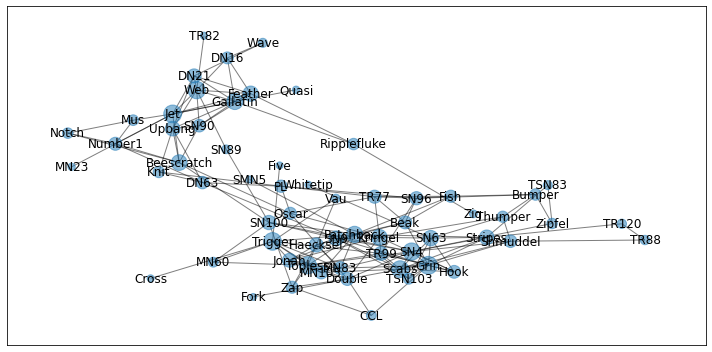

In [10]:

pos=nx.spring_layout(gml_graph,k=3/np.sqrt(N))

node_size = [v * 10000 for v in X[-1]]


f1,ax = plt.subplots(1,1,figsize=(10,5))
nx.draw_networkx_edges(gml_graph,         
        pos=pos, 
        ax = None,
        alpha=.5)

nx.draw_networkx_nodes(gml_graph, 
        pos=pos, 
        ax = None,
        node_size=node_size,
        alpha=.5)
        
labels = nx.draw_networkx_labels(gml_graph, pos=pos,ax=None)

f1.patch.set_visible(False)
#ax[0].axis('off')

#nx.draw(gml_graph,
      #  pos=pos,
      #  ax = ax[1],
      #  node_size=node_size,
      #  node_color=X[-1],
      #  alpha=.5,
      #  cmap='Wistia')

plt.tight_layout()
plt.savefig('Dolphins2.pdf')




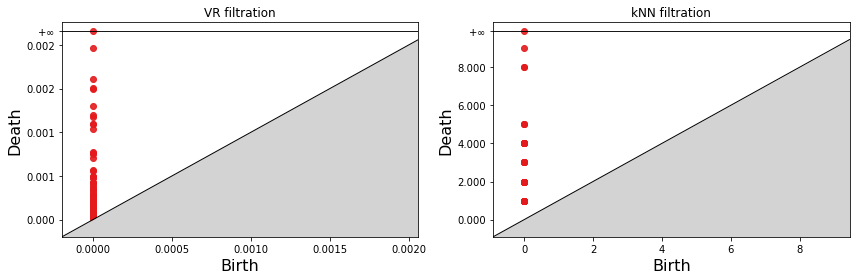

In [11]:
f1,ax = plt.subplots(1,2,figsize=(12,4))

filtration_steps = linspace(0,1,1000)
ids = arange(N)

nodes = rowvect2D(X[-1])
dn=dists(nodes,nodes)

FINAL_diag_VR=dist2PD(dn,2,1)[1]
gd.plot_persistence_diagram(persistence=FINAL_diag_VR,alpha = .9,axes=ax[0]);
title('VR filtration')


FINAL_neighbor_order_matrix = neighbor_ordering(nodes,'max')
FINAL_neighbor_order_matrix_min = neighbor_ordering(nodes,'min')


FINAL_diag_kNN=dist2PD(FINAL_neighbor_order_matrix,1,13)[1]
FINAL_diag_kNN_min=dist2PD(FINAL_neighbor_order_matrix_min,1,13)[1]

gd.plot_persistence_diagram(persistence=FINAL_diag_kNN,alpha = .9,axes=ax[1]);
ax[0].set_title('VR filtration')
ax[1].set_title('kNN filtration')


plt.tight_layout()
plt.savefig('dolphin_PD.pdf')

C:\Users\MINHLE~1\AppData\Local\Temp/ipykernel_36412/3465049202.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


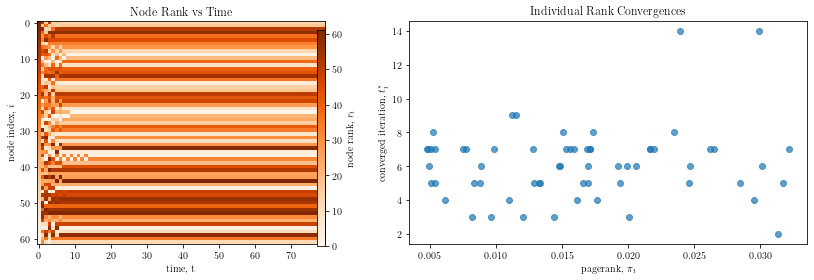

In [12]:
def plot_ranks_vs_time(X,fig,ax):

    ranks = zeros(shape(X))
    for t in range(len(X)):
        ranks[t] = argsort(-X[t])
    plott = ax.imshow(ranks.T,cmap='Oranges');    
    ax.set_title('Node Rank vs Time')
    ax.set_ylabel('node index, $i$')
    ax.set_xlabel('time, t')
    
    cbaxes = fig.add_axes([0.42, 0.13, 0.01, 0.75])
    cb = plt.colorbar(plott, cax = cbaxes,orientation='vertical')
    cbaxes.set_ylabel('node rank, $r_i$')

    return ranks

f1,ax = plt.subplots(1,2,figsize=(12,4))
ranks = plot_ranks_vs_time(X[:,:],fig=f1,ax=ax[0])  

converged_ranks = (1-(abs(ranks - ranks[-1])>0)*1)


time_converged = zeros(N)
for n in range(N):
    time_converged[n] = where(converged_ranks[:,n]==0)[0][-1]    
ax[1].scatter(X[-1],time_converged+1,alpha=.7)    
ax[1].set_xlabel('pagerank, $\pi_i$')
ax[1].set_ylabel('converged iteration, $t^*_i$')
ax[1].set_title('Individual Rank Convergences')


plt.tight_layout()
plt.savefig('dolphins_agh.pdf')

In [13]:
bottle_distances_VR = zeros(T)
bottle_distances_kNN = zeros(T)
bottle_distances_kNN_min = zeros(T)
matrix_norm = zeros(T)
for t in range(T):
    nodes=rowvect2D(X[t])

    # VR filtration comparisons
    dn=dists(nodes,nodes)    
    diag_VR=dist2PD(dn,2,1)[1]
    bottle_distances_VR[t] = bottleneck(diag_VR,FINAL_diag_VR)[0]

    # kNN filtration comparisons    
    neighbor_order_matrix = neighbor_ordering(nodes,'max')
    diag_kNN=dist2PD(neighbor_order_matrix,1,13)[1]
    bottle_distances_kNN[t] = bottleneck(diag_kNN,FINAL_diag_kNN)[0]
    bottle_distances_kNN[t] = bottle_distances_kNN[t] * (bottle_distances_kNN[t]>10**(-16))
    
    matrix_norm[t] =  np.sum(np.triu(FINAL_neighbor_order_matrix) != np.triu(neighbor_order_matrix))*1/N/(N-1)*2
    
    neighbor_order_matrix_min = neighbor_ordering(nodes,'min')
    diag_kNN_min=dist2PD(neighbor_order_matrix_min,1,13)[1]
    bottle_distances_kNN_min[t] = bottleneck(diag_kNN_min,FINAL_diag_kNN_min)[0]
    bottle_distances_kNN_min[t] = bottle_distances_kNN_min[t] * (bottle_distances_kNN_min[t]>10**(-16))


In [14]:
diff_X = array([ norm(X[t] - X[-1]) for t in range(len(X))] )
diff_ranks = np.sum(abs(ranks - ranks[-1])>0,1)
iters_to_convergence = where(diff_ranks>0)[0][-1]
iters_to_convergence

13

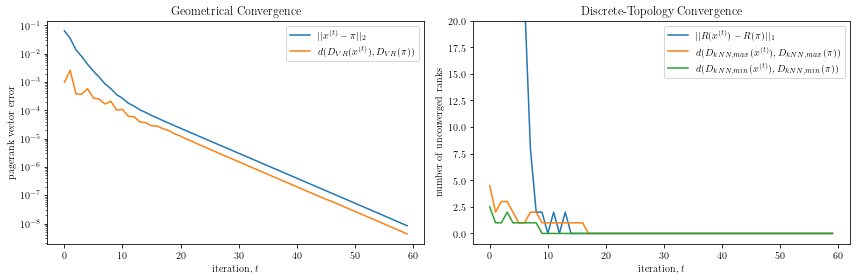

In [15]:
f1,ax = plt.subplots(1,2,figsize=(12,4))

its = arange(60)

ax[0].semilogy(diff_X[its])
ax[0].semilogy((bottle_distances_VR[its]))
ax[0].set_title('Geometrical Convergence')
ax[0].legend(['$||x^{(t)} -\pi||_2$','$d(D_{VR}(x^{(t)}),D_{VR}(\pi))$'])

ax[1].plot(diff_ranks[its])
ax[1].plot((bottle_distances_kNN[its]))
ax[1].plot((bottle_distances_kNN_min[its]))
ax[1].set_title('Discrete-Topology Convergence')
ax[1].legend(['$||R(x^{(t)}) -R(\pi)||_1$','$d(D_{kNN,max}(x^{(t)}),D_{kNN,max}(\pi))$','$d(D_{kNN,min}(x^{(t)}),D_{kNN,min}(\pi))$'])
ax[1].set_ylim([-1,20])


ax[0].set_xlabel('iteration, $t$')
ax[1].set_xlabel('iteration, $t$')

ax[0].set_ylabel('pagerank vector error')
ax[1].set_ylabel('number of unconverged ranks')



#ax[1].plot((matrix_norm[:-1]))
#ax[3].plot(diff_ranks[:-1])
#ax[3].set_title('Number of Different NNOs')
plt.tight_layout()
plt.savefig('Dolphins_convergence.pdf')


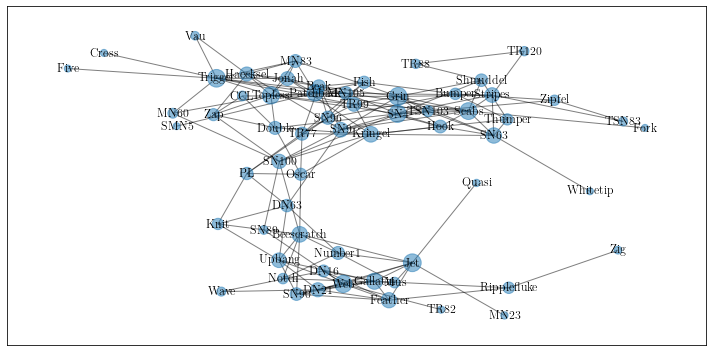

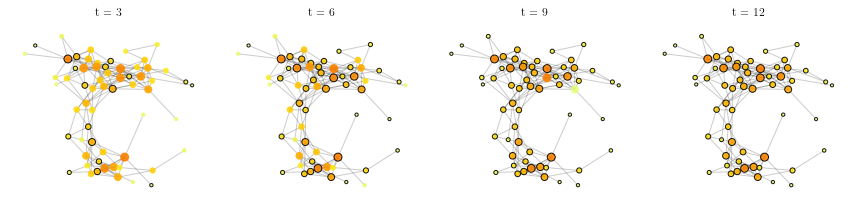

In [16]:
#import operator

#pr4=nx.pagerank(gml_graph,alpha=0.85)
#sorted_pr4=sorted(pr4.items(),key=operator.itemgetter(1))
#dict_pr4=dict(pr4)


pos=nx.spring_layout(gml_graph,k=3/np.sqrt(N))

node_size = [v * 10000 for v in X[-1]]


f1,ax = plt.subplots(1,1,figsize=(10,5))
nx.draw_networkx_edges(gml_graph,         
        pos=pos, 
        ax = None,
        alpha=.5)

nx.draw_networkx_nodes(gml_graph, 
        pos=pos, 
        ax = None,
        node_size=node_size,
        alpha=.5)
        
labels = nx.draw_networkx_labels(gml_graph, pos=pos,ax=None)

f1.patch.set_visible(False)

plt.tight_layout()
plt.savefig('Dolphinss.pdf')

#pos=nx.spring_layout(gml_graph,k=3/np.sqrt(N))

node_size = [v * 2000 for v in X[-1]]

ts = [3,6,9,12]

f1.patch.set_visible(False)




converged_ranks = (1-(abs(ranks - ranks[-1])>0)*1)



f1,ax = plt.subplots(1,len(ts),figsize=(12,3))
for i,t in enumerate(ts):
    nx.draw_networkx_edges(gml_graph,         
                            pos=pos, 
                            ax = ax[i],
                            alpha=.2)

    ids_conv = where(converged_ranks[t])[0]    
    nodelist = [list(gml_graph.nodes)[i] for i in ids_conv]
    
    nx.draw_networkx_nodes(gml_graph, 
                            pos={key: pos[key] for key in nodelist}, 
                            ax = ax[i],
                            nodelist = [list(gml_graph.nodes)[i] for i in ids_conv],
                            node_size=[node_size[i] for i in ids_conv],
                            node_color=X[t,ids_conv],
                            alpha=.9,
                            cmap='Wistia')

    ids_not_conv = where(converged_ranks[t]==0)[0]    
    nodelist = [list(gml_graph.nodes)[i] for i in ids_not_conv]    
    nx.draw_networkx_nodes(gml_graph, 
                            pos={key: pos[key] for key in nodelist}, 
                            ax = ax[i],
                            nodelist = [list(gml_graph.nodes)[i] for i in ids_not_conv],
                            node_size=[node_size[i] for i in ids_not_conv],
                            node_color=X[t,ids_not_conv],
                            alpha=.9,
                            cmap='Wistia')
    
    ax[i].axis('off')
    axdd = plt.gca() # to get the current axis
    ax[i].collections[1].set_edgecolor("#000000") 
    ax[i].set_title('t = '+str(t))


plt.tight_layout()
plt.savefig('Dolphins_iterations1.pdf')




# U-LOCAL CONVERGENCE IN MODEL

### select nodes with largest degree

In [17]:
degrees = np.array([val for (node, val) in gml_graph.degree()])

In [18]:
def Bottleneck_VR_local(X,X_local,T):
    p = len(X_local)
    nodesl = zeros([p,2])
    nodesfl = zeros([p,2])

    bottle_distances_VRl = zeros(T)
    nodesf = rowvect2D(X[-1])
    for t in range(T):
        nodes=rowvect2D(X[t])
        for i in range(p):
            nodesl[i] = nodes[X_local[i]]   
            nodesfl[i] = nodesf[X_local[i]]
        dnl = dists(nodesl,nodesl)
        dnlf = dists(nodesfl,nodesfl)
        diag_VRl=dist2PD(dnl,2,1)[1]
        FINAL_diag_VRl = dist2PD(dnlf,2,1)[1]
        bottle_distances_VRl[t] = bottleneck(diag_VRl,FINAL_diag_VRl)[0]
    return bottle_distances_VRl
    
    
    
 

In [19]:
def Bottleneck_kNN_local(X, # full dataset
                         X_local, # local dataset
                         T): # time of iteration
    p = len(X_local)
    nodesl = zeros([p,2])
    nodesfl = zeros([p,2])

    bottle_distances_kNNl = zeros(T)
    for t in range(T):
        nodes=rowvect2D(X[t])
        nodesf=rowvect2D(X[-1])

        for i in range(p):
            nodesl[i] = nodes[X_local[i]]
            nodesfl[i] = nodesf[X_local[i]]

        neighbor_order_matrix = neighbor_ordering(nodesl,'max')

        FINAL_neighbor_order_matrix = neighbor_ordering(nodesfl,'max')
        FINAL_diag_kNNl=dist2PD(FINAL_neighbor_order_matrix,1,13)[1]
        diag_kNNl=dist2PD(neighbor_order_matrix,1,13)[1]
        bottle_distances_kNNl[t] = bottleneck(diag_kNNl,FINAL_diag_kNNl)[0]
        bottle_distances_kNNl[t] = bottle_distances_kNNl[t] * (bottle_distances_kNNl[t]>10**(-16))
    return bottle_distances_kNNl

In [20]:
def Bottleneck_kNN_min_local(X,X_local,T):
    p = len(X_local)
    nodesl = zeros([p,2])
    bottle_distances_kNN_minl = zeros(T)
    nodesfl = zeros([p,2])

    for t in range(T):
        nodes=rowvect2D(X[t])
        nodesf=rowvect2D(X[-1])

        for i in range(p):
            nodesl[i] = nodes[X_local[i]]
            nodesfl[i] = nodesf[X_local[i]]

        neighbor_order_matrix_min = neighbor_ordering(nodesl,'min')
        FINAL_neighbor_order_matrix_min = neighbor_ordering(nodesfl,'min')
        FINAL_diag_kNN_minl=dist2PD(FINAL_neighbor_order_matrix_min,1,13)[1]
        diag_kNN_minl=dist2PD(neighbor_order_matrix_min,1,13)[1]
        bottle_distances_kNN_minl[t] = bottleneck(diag_kNN_minl,FINAL_diag_kNN_minl)[0]
        bottle_distances_kNN_minl[t] = bottle_distances_kNN_minl[t] * (bottle_distances_kNN_minl[t]>10**(-16))
    return bottle_distances_kNN_minl

In [21]:
def make_convergence_figs(X,X_local,T,t):
    ranksl = zeros((T,p))
    f1,ax = plt.subplots(1,2,figsize=(12,4))
    diff_X = array([ norm(X[t,X_local] - X[-1,X_local]) for t in range(len(X))] )
    for t in range(T):
        ranksl[t] = argsort(-X[t,X_local])
    
        diff_ranks = np.sum(abs(ranksl - ranksl[-1])>0,1)

    its = arange(t)
    ax[0].semilogy(diff_X[its])
    ax[0].semilogy(Bottleneck_VR_local(X,X_local,T)[its])
    ax[0].set_title('Local Geometrical Convergence')
    ax[0].legend(['$||x^{(t)} -\pi||_2$','$d(D_{VRl}(x^{(t)}),D_{VRl}(\pi))$'])

    ax[1].plot(diff_ranks[its])
    ax[1].plot(Bottleneck_kNN_local(X,X_local,T)[its])
    ax[1].plot(Bottleneck_kNN_min_local(X,X_local,T)[its])
    ax[1].set_title('Local Discrete Topological Convergence')
    ax[1].legend(['$||R(x^{(t)}) -R(\pi)||_1$','$d(D_{kNNl,max}(x^{(t)}),D_{kNNl,max}(\pi))$','$d(D_{kNNl,min}(x^{(t)}),D_{kNNl,min}(\pi))$'])
    ax[1].set_ylim([-1,10])


    ax[0].set_xlabel('iteration, $t$')
    ax[1].set_xlabel('iteration, $t$')

    ax[0].set_ylabel('pagerank vector error')
    ax[1].set_ylabel('number of unconverged ranks')



    plt.tight_layout()


    return f1,ax

In [22]:
p=10

node_names = ['Ripplefluke','Zig','Feather','Gallatin','SN90' ,'DN16','Wave','DN21','Web','Upbang']
full_node_names = list(gml_graph.nodes)

node_id = {}
counter = 0
for name in full_node_names:
    node_id[name] = counter
    counter = counter + 1

local_node_set = []
for name in node_names:

    local_node_set.append(node_id[name])
    


In [23]:
local_node_set = np.array(local_node_set)

In [24]:
Bottleneck_VR_local(X,local_node_set,80)
Bottleneck_VR_local

<function __main__.Bottleneck_VR_local(X, X_local, T)>

In [25]:
p=10
top_10_nodes = argsort(-degrees)[:p]
top_10_nodes

array([14, 37, 45, 33, 51, 57, 20, 17, 29,  1], dtype=int64)

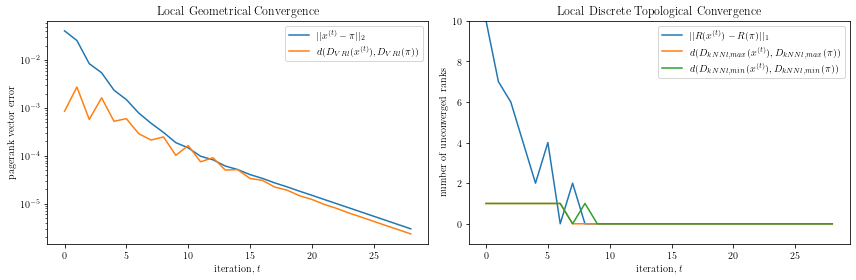

In [26]:

make_convergence_figs(X,top_10_nodes,30,30)
savefig('top10.pdf')

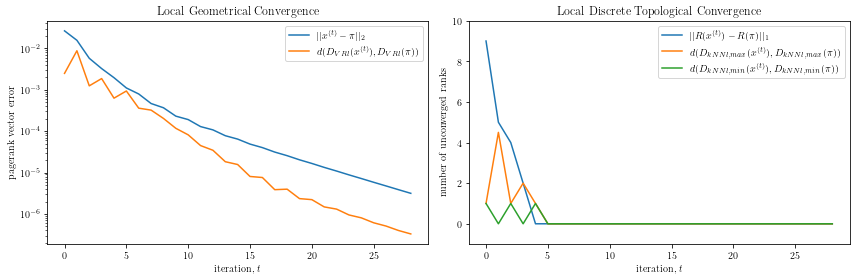

In [27]:
make_convergence_figs(X,local_node_set,30,30)
savefig('loc.pdf')